
# Training The CNN to identify karstified areas


In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

import tensorflow.keras

import os

import timeit

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import datetime

In [19]:
%load_ext tensorboard

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Importing the Data

In [3]:
path = "D:/Masterarbeit/Data/Balkans/data/data_balkans_modified.npz"
filename = "data_balkans.npz"
categorical = True
batch_size = 20

In [4]:
from Data import get_data_from_npz, load_image_train, load_image_test, display

In [5]:
train_examples, test_examples, train_labels_category, test_labels_category = get_data_from_npz(path, filename, categorical)

In [6]:
train_examples, test_examples, train_labels_category, test_labels_category = train_examples[0:6600, :, :, :], test_examples[0:1660, :, :, :], train_labels_category[0:6600, :, :, :], test_labels_category[0:1660, :, :, :] 

## Setting training Parameters

In [7]:
TRAIN_LENGTH = 6600
BATCH_SIZE = 20
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

## Format the data as tfRecord

In [8]:
train = tf.data.Dataset.from_tensor_slices((train_examples, train_labels_category)).map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test =  tf.data.Dataset.from_tensor_slices((test_examples, test_labels_category)).map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
# Treat every instance of class 1 as 50 instances of class 0 to account for biased data
class_weights = {0: 1.,
                1: 50.}

In [10]:
print("number of samples:" + str(test_examples.shape[0] + train_examples.shape[0]))

number of samples:8260


## Visualize Input Data

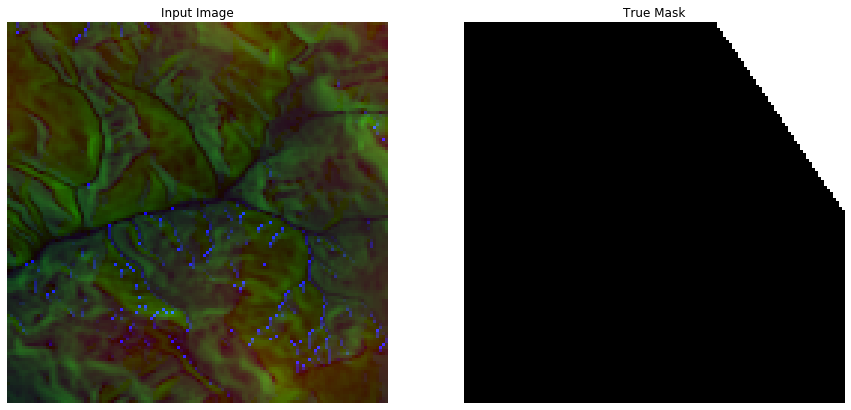

In [39]:
for image, mask in train.take(5000):
      sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### Import the model

In [12]:
from Model import make_KaI, create_mask, show_predictions

In [13]:
model = make_KaI((128,128,3),2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Using TensorFlow backend.


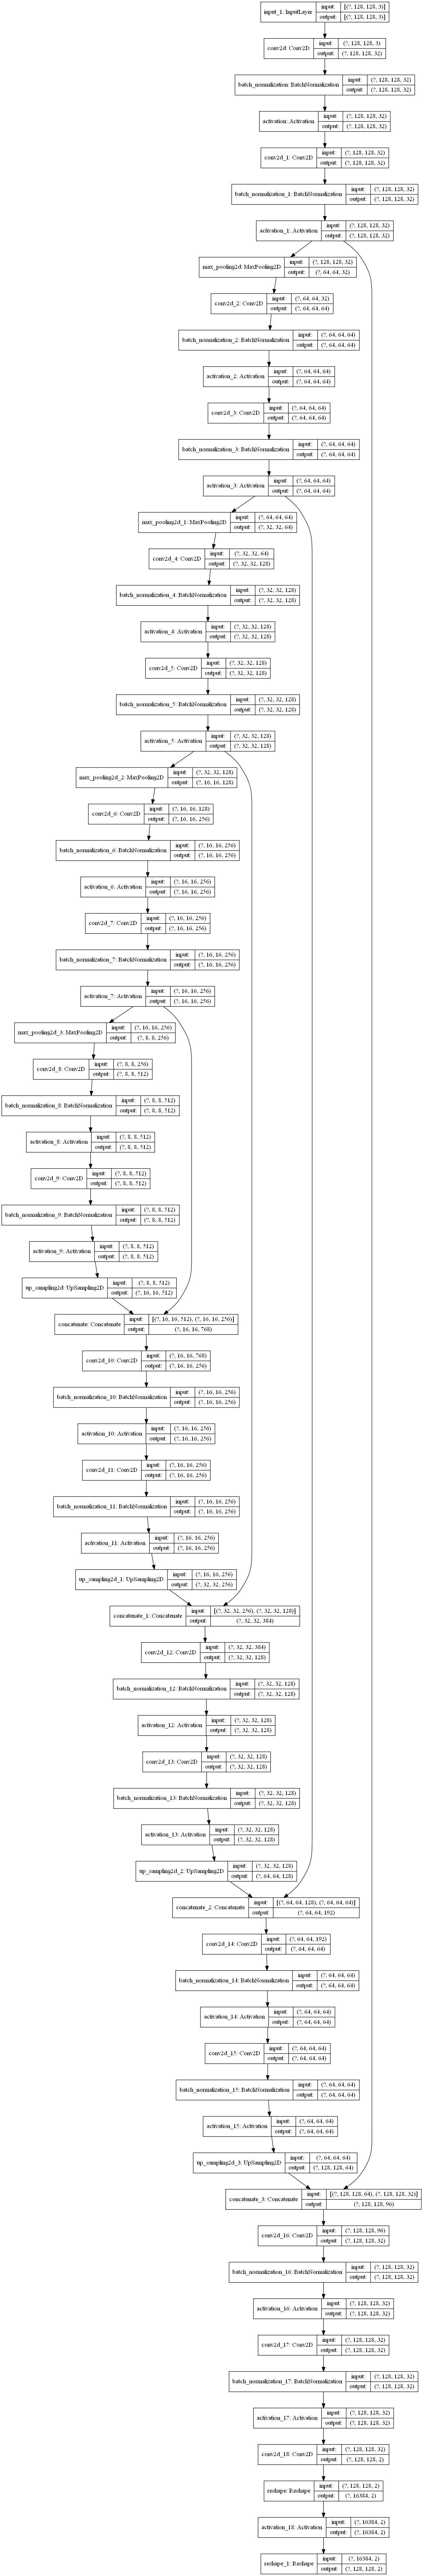

In [15]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(model, to_file="D:/Masterarbeit/Data/Randbereiche/model_full_unpool.png", show_shapes=True)

### Compile the model

In [14]:
sgd = tf.keras.optimizers.SGD(lr=1e-5)
adam = tf.keras.optimizers.Adam(lr=0.001)
adadelta = tf.keras.optimizers.Adadelta(lr=1e-5)

In [15]:
model.compile(optimizer=adam,
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

### Fit the model 

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [34]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1660//BATCH_SIZE//VAL_SUBSPLITS

start = timeit.default_timer()

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          class_weight = class_weights,
                          callbacks=[tensorboard_callback])

stop = timeit.default_timer()
print(stop-start)

Train for 330 steps, validate for 16 steps
Epoch 1/10
330/330 [==============================] - 2850s 9s/step - loss: nan - acc: 0.7407 - val_loss: nan - val_acc: 0.7004
Epoch 2/10
330/330 [==============================] - 2844s 9s/step - loss: nan - acc: 0.7179 - val_loss: nan - val_acc: 0.7004
Epoch 3/10
330/330 [==============================] - 2852s 9s/step - loss: nan - acc: 0.7179 - val_loss: nan - val_acc: 0.7004
Epoch 4/10
330/330 [==============================] - 2846s 9s/step - loss: nan - acc: 0.7179 - val_loss: nan - val_acc: 0.7004
Epoch 5/10
330/330 [==============================] - 2846s 9s/step - loss: nan - acc: 0.7179 - val_loss: nan - val_acc: 0.7004
Epoch 6/10
330/330 [==============================] - 2842s 9s/step - loss: nan - acc: 0.7179 - val_loss: nan - val_acc: 0.7004
Epoch 7/10
330/330 [==============================] - 2842s 9s/step - loss: nan - acc: 0.7179 - val_loss: nan - val_acc: 0.7004
Epoch 8/10
330/330 [==============================] - 2844s 9

In [36]:
%tensorboard --logdir "logs/fit"

Reusing TensorBoard on port 6006 (pid 14536), started 7:50:27 ago. (Use '!kill 14536' to kill it.)

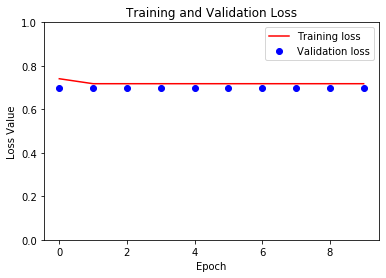

In [37]:
loss = model_history.history['acc']
val_loss = model_history.history['val_acc']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [40]:
show_predictions()

NameError: name 'sample_image' is not defined

## View training history

In [28]:
print(model_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [24]:
model.save("D:/Masterarbeit/Data/Balkans/CNN_06.hdf5")

In [25]:
from tensorflow.keras.models import load_model
model = load_model('D:/Masterarbeit/Data/Balkans/CNN_06.hdf5')

C:\Users\Veigel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Veigel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


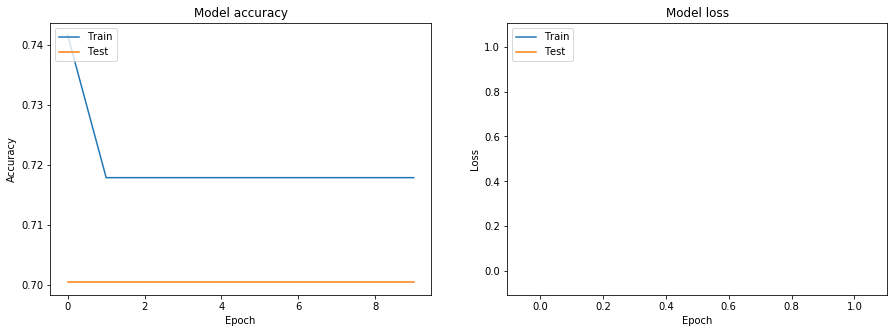

In [26]:
with PdfPages("C:/Users/Veigel/Pictures/Memos/training_loss_balkans.pdf") as pdf:
# Plot training & validation accuracy values
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(model_history.history['acc'])
    ax1.plot(model_history.history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')
    fig.show()
        
        # Plot training & validation loss values
    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper left')
    fig.show()
    #pdf.savefig(fig)

In [27]:
plt.close(fig="all")

## Make Predictions

In [52]:
predictions = model.predict(test_examples)
#preds_reshape = predictions.reshape(num_samples_val, 100,100,2)

In [54]:
preds = np.argmax(predictions, axis=-1)

In [55]:
#print(preds_reshape.shape)
print(preds.shape)
#print(preds_reshape[19,:,:,0])
print(preds[19,:,:])

(1665, 128, 128)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
